In [43]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy
import sys
import pandas as pd
from astropy.io import fits
from scipy import interpolate 
from astropy.convolution import convolve_fft, CustomKernel, convolve
from astropy import units as u
from astropy import constants as const
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region
from specutils.spectra.spectrum1d import Spectrum1D
from specutils.fitting.continuum import fit_continuum
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
c = 2.99792458e10 # cm/s, speed of light
k = 1.38064852e-16# cgs, Boltzmann constant
m = 4.68e-23
h = 6.62606876e-27



In [44]:
def process_data(file_path):
    col_names = ('Branch','J','Lambda','s1','s2','o', 'f', 'cross_section')
    data = pd.read_csv(file_path,
                       header=None,
                       names=col_names,
                       delimiter=' ',
                       skipinitialspace=True,
                       error_bad_lines=False)
    
    data['cross_section'] = pd.to_numeric(data['cross_section'], errors='coerce')
    data['f'] = pd.to_numeric(data['f'], errors='coerce')
    
    Lambda = np.array(data['Lambda']) * 1e-8
    J = np.array(data['J'])
    f = np.array(data['f'])
    #This conversion of oscillator strengths to cross sections is specific to the oscillator strengths listed in MOLAT
    cross_section = f * 0.0265
    
    return Lambda, J, f, cross_section

# Grab the energy levels, weights and J levels for CO these where taken from LAMBA
energy_file_path = "/Users/aoifebrennan/HST_project/HST_data/CO_bands/Energy_list.txt"
col_names = ('Level','Energy','Weight','J_Level')
data1 = pd.read_csv(energy_file_path,
                    header=None,
                    names=col_names,
                    delimiter=' ',
                    skipinitialspace=True,
                    error_bad_lines=False)

Energy = np.array(data1['Energy'])
Weight = np.array(data1['Weight'])
J_Level = np.array(data1['J_Level'])


# In this tutorial we'll fit two different bands at 1517 A and 1535 A.
# The wavelengths, J levels, oscillator strengths and cross_sections where taken from MOLAT

file_path = "/Users/aoifebrennan/HST_project/HST_data/CO_bands/1517_band.txt"
Lambda_1517, J_1517, f_1517, cross_section_1517 = process_data(file_path)

file_path = "/Users/aoifebrennan/HST_project/HST_data/CO_bands/1535_band.txt"
Lambda_1535, J_1535, f_1535, cross_section_1535 = process_data(file_path)

/Users/aoifebrennan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/sc/94zwnp8x1h38qtbrv6p83hd80000gn/T/ipykernel_1662/740904645.py:40: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  Lambda_1517, J_1517, f_1517, cross_section_1517 = process_data(file_path)
/var/folders/sc/94zwnp8x1h38qtbrv6p83hd80000gn/T/ipykernel_1662/740904645.py:43: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  Lambda_1535, J_1535, f_1535, cross_section_1535 = process_data(file_path)


In [45]:
# Extract order from 1535 band

file=['/Users/aoifebrennan/HST_project/HST_data/HST_data/oe4v09020_x1d.fits']
for i in np.arange(len(file)):
    x1ddata = fits.getdata(file[i], ext=1)
    norders = len(x1ddata)
    nwavs = len((x1ddata[0]['WAVELENGTH']))
    order = np.arange(norders)
    wave = x1ddata[:]['WAVELENGTH']
    flux = x1ddata[:]['FLUX']
    err = x1ddata[:]['ERROR']
    
wave = np.stack((wave[18], wave[19]))
flux = np.stack((flux[18], flux[19]))
err = np.stack((err[18], err[19]))
print(wave)

W_final, F_final, err_final = main(wave, flux, err)
W_final = np.array(W_final)*1e-8

[[1538.37755237 1538.38449691 1538.39144112 ... 1545.30036089
  1545.30698447 1545.31360774]
 [1532.74302834 1532.74994615 1532.75686361 ... 1539.63926663
  1539.64586486 1539.6524628 ]]


(1.5348e-05, 1.54e-05)

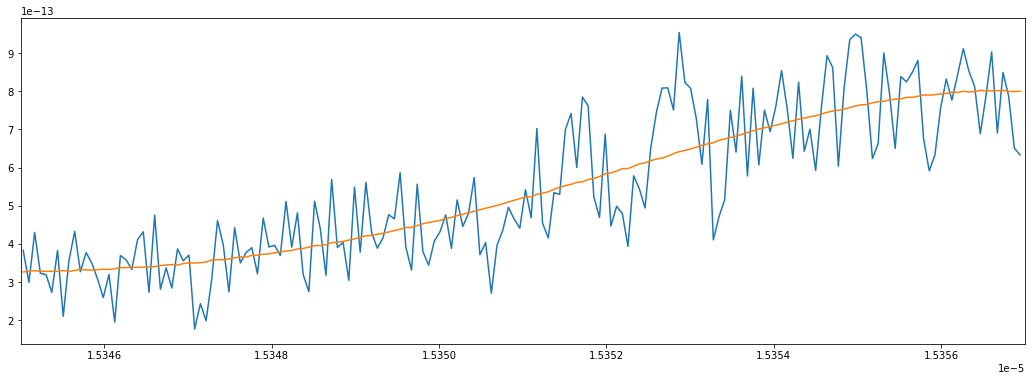

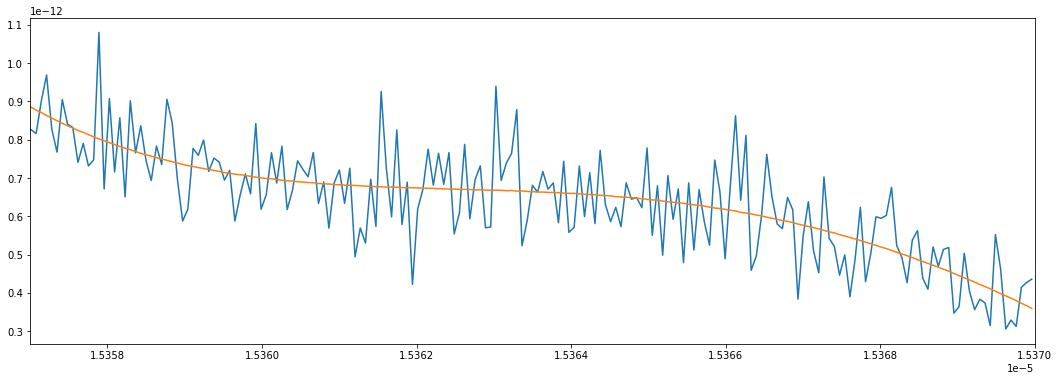

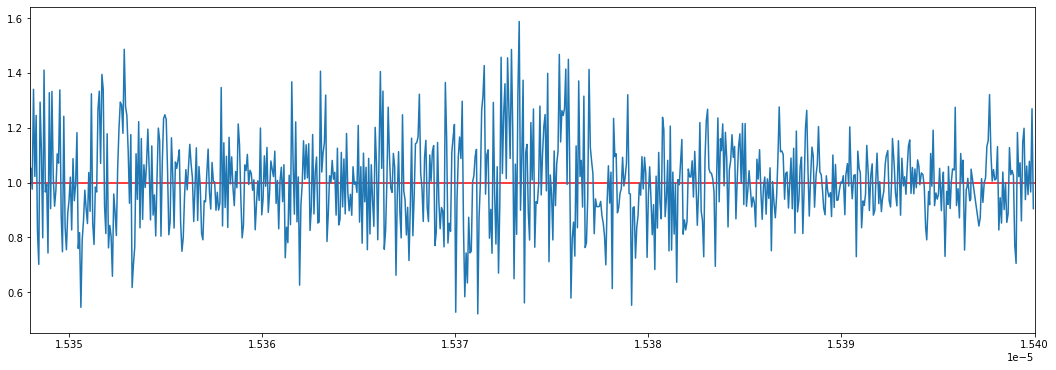

In [46]:
#Extract and fit relevant line free regions of spectrum

min = 1534.5e-8
max = 1535.7e-8
index = [(j) for j, item in enumerate(W_final) if (item > min).any() and (item < max).any()]
flux_data_1 = np.take(F_final, index)
lambda_data_1 = (np.take(W_final, index))
yerr_data_1 = np.take(err_final, index)

min = 1535.7e-8
max = 1537e-8
index = [(j) for j, item in enumerate(W_final) if (item > min).any() and (item < max).any()]
flux_data_2 = np.take(F_final, index)
lambda_data_2 = (np.take(W_final, index))
yerr_data_2 = np.take(err_final,index)

min = 1537e-8
max = 1540e-8
index = [(j) for j, item in enumerate(W_final) if (item > min).any() and (item < max).any()]
flux_data_3 = np.take(F_final, index)
lambda_data_3 = (np.take(W_final, index))
yerr_data_3 = np.take(err_final, index)


region = [ (1534.5e-8*u.cm, 1535.05e-8*u.cm), (1535.35e-8*u.cm, 1535.45e-8*u.cm),
          (1535.61e-8*u.cm, 1535.67e-8*u.cm)]


spectrum = Spectrum1D(flux=flux_data_1 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data_1 * u.cm)
fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(6), window = region)
y_fit_a = fitted_continuum(lambda_data_1*u.cm)

f, ax = plt.subplots()  
#pl.figure(figsize=(18,6))
f.set_size_inches(18, 6)
ax.plot(lambda_data_1, flux_data_1)  
ax.plot(lambda_data_1, y_fit_a)  
#plt.ylim(0, 1.5)
plt.xlim(1534.5e-8, 1535.7e-8)

spec_normalized = spectrum / y_fit_a
lambda_data_1 = spec_normalized.spectral_axis
flux_data_1 = spec_normalized.flux
yerr_data_1 = (yerr_data_1/y_fit_a)/(u.erg**-1*u.A*u.cm**2*u.s)


spectrum = Spectrum1D(flux=flux_data_2 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data_2 * u.cm)
region = [(1535.7e-8*u.cm, 1535.87e-8*u.cm),
          (1535.92e-8*u.cm, 1536.18e-8*u.cm), (1536.22e-8*u.cm, 1537e-8*u.cm)]
        
fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(6))
y_fit_a = fitted_continuum(lambda_data_2*u.cm)

f, ax = plt.subplots()  
#pl.figure(figsize=(18,6))
f.set_size_inches(18, 6)
ax.plot(lambda_data_2, flux_data_2)  
ax.plot(lambda_data_2, y_fit_a)  
#plt.ylim(0, 1.5)
plt.xlim(1535.7e-8, 1537e-8)

spec_normalized = spectrum / y_fit_a
lambda_data_2 = spec_normalized.spectral_axis
flux_data_2 = spec_normalized.flux
yerr_data_2 = (yerr_data_2/y_fit_a)/(u.erg**-1*u.A*u.cm**2*u.s)

spectrum = Spectrum1D(flux=flux_data_3 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data_3 * u.cm)      
fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(6))
y_fit_a = fitted_continuum(lambda_data_3*u.cm)


spec_normalized = spectrum / y_fit_a
lambda_data_3 = spec_normalized.spectral_axis
flux_data_3 = spec_normalized.flux
yerr_data_3 = (yerr_data_3/y_fit_a)/(u.erg**-1*u.A*u.cm**2*u.s)

lambda_data_1535 = np.concatenate([lambda_data_1, lambda_data_2, lambda_data_3])
flux_data_1535 = np.concatenate([flux_data_1, flux_data_2, flux_data_3])
yerr_data_1535 = np.concatenate([yerr_data_1, yerr_data_2, yerr_data_3])

#print(yerr_data_1535)
f, ax = plt.subplots()  
#pl.figure(figsize=(18,6))
plt.axhline(y=1, color='r', linestyle='-')
f.set_size_inches(18, 6)
ax.plot(lambda_data_1535, flux_data_1535)  
#plt.ylim(0, 1.5)
plt.xlim(1534.8e-8, 1540e-8)

In [47]:
#create a new array of the wavelength (from line list) + delta lambda, this will make it easier to compare line list to data
#also convert from Angstrom to cm as all units used are cgs
Lambda_list = []
Lambda = (Lambda_1517)*1e-8
delta_lambda =  (((3*100000)/c)*1517e-8)
for i in (Lambda_1517):
    Lambda_list.append(i+delta_lambda)


file=['/Users/aoifebrennan/HST_project/HST_data/HST_data/oe4v09020_x1d.fits']
date=['FUV']
colors=['royalblue']
plt.figure()
for i in np.arange(len(file)):
    x1ddata = fits.getdata(file[i], ext=1)
    norders = len(x1ddata)
    nwavs = len((x1ddata[0]['WAVELENGTH']))
    order = np.arange(norders)
    wave = x1ddata[:]['WAVELENGTH']
    flux = x1ddata[:]['FLUX']
    err = x1ddata[:]['ERROR']

#grab the desired order and section of wavelength array
#grab corresponding flux/ errors for spectrum section
#convert data wavelength to cm
#The order has been broken into two sections for each observations to make continuum fitting easier

W = (wave[22])
F = (flux[22])
E = (err[22])
min = 1517.5
max = 1518.65
wavelength = []
index = [(j) for j, item in enumerate(W) if (item > min).any() and (item < max).any()]
flux_data1 = np.take(F, index)
lambda_data1 = (np.take(W, index))*(1e-8)
yerr_data1 = np.take(E,index)

min = 1518.65
max = 1519.55
index = [(j) for j, item in enumerate(W) if (item > min).any() and (item < max).any()]
flux_data2 = np.take(F, index)
lambda_data2 = (np.take(W, index))*(1e-8)
yerr_data2 = np.take(E,index)

min = 1519.55
max = 1520.7
index = [(j) for j, item in enumerate(W) if (item > min).any() and (item < max).any()]
flux_data3 = np.take(F, index)
lambda_data3 = (np.take(W, index))*(1e-8)
yerr_data3 = np.take(E,index)

min = 1520.7
max = 1522
index = [(j) for j, item in enumerate(W) if (item > min).any() and (item < max).any()]
flux_data4 = np.take(F, index)
lambda_data4 = (np.take(W, index))*(1e-8)
yerr_data4 = np.take(E,index)

<Figure size 432x288 with 0 Axes>

(1.5175e-05, 1.522e-05)

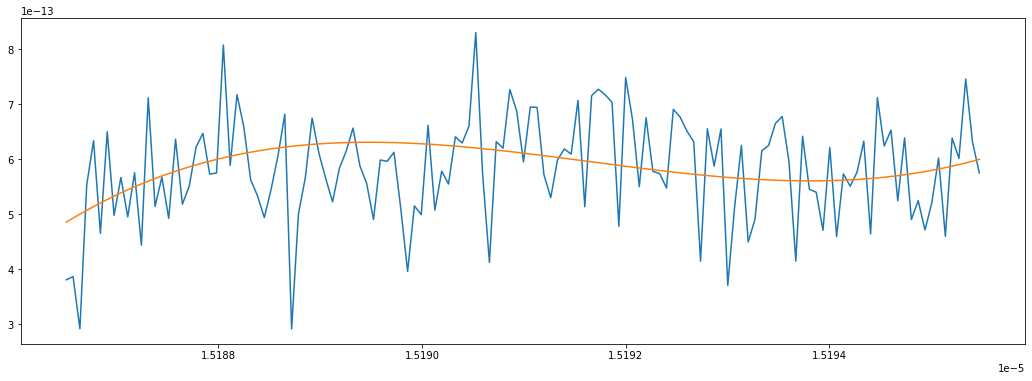

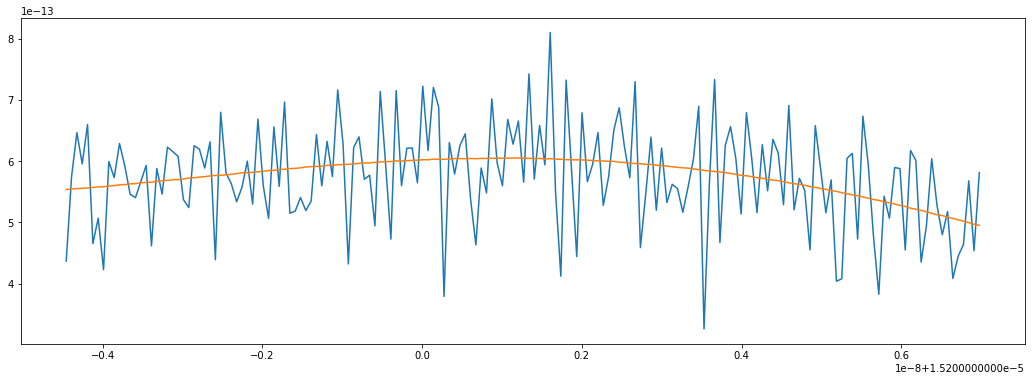

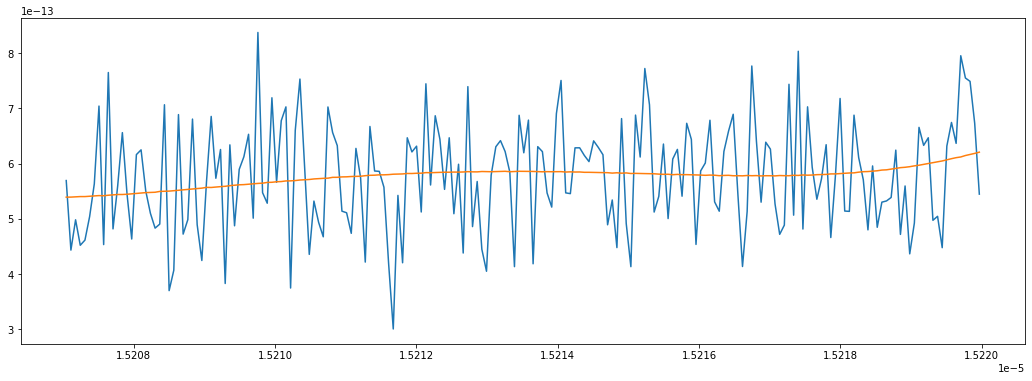

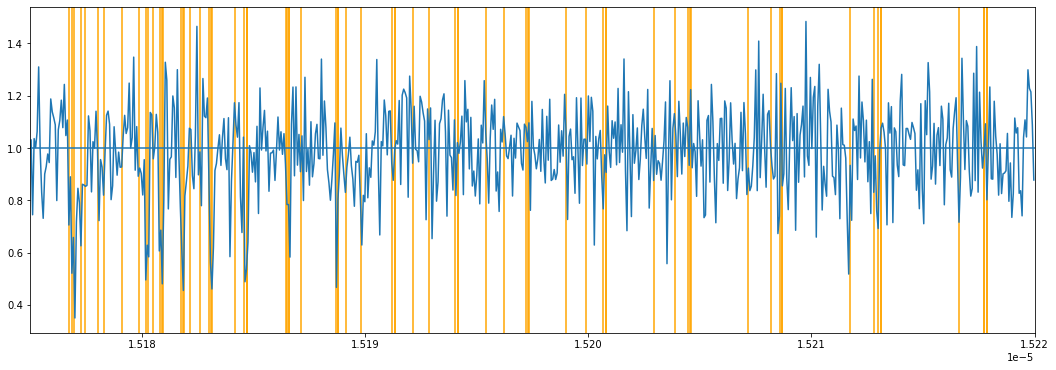

In [48]:


spectrum = Spectrum1D(flux=flux_data1 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data1 * u.cm)
region = [ (1517.5e-8*u.cm, 1517.68e-8*u.cm), (1517.8e-8*u.cm, 1517.95e-8*u.cm),(1518.5e-8*u.cm, 1518.65e-8*u.cm)]

fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(3), window = region)
y_fit_a1 = fitted_continuum(lambda_data1*u.cm)

spec_normalized = spectrum / y_fit_a1
lambda_data1 = spec_normalized.spectral_axis
flux_data1 = spec_normalized.flux
yerr_data1 = (yerr_data1/y_fit_a1)/(u.erg**-1*u.A*u.cm**2*u.s)

spectrum = Spectrum1D(flux=flux_data2 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data2 * u.cm)
spectrum = Spectrum1D(flux=flux_data2 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data2 * u.cm)
region = [ (1518.75e-8*u.cm, 1518.85e-8*u.cm), (1519e-8*u.cm, 1519.1e-8*u.cm),
         (1519.45e-8*u.cm, 1519.55e-8*u.cm)]

fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(3), window = region)
y_fit_a2 = fitted_continuum(lambda_data2*u.cm)

f, ax = plt.subplots()  
f.set_size_inches(18, 6)
ax.plot(lambda_data2, flux_data2)
ax.plot(lambda_data2, y_fit_a2)

spec_normalized = spectrum / y_fit_a2
lambda_data2 = spec_normalized.spectral_axis
flux_data2 = spec_normalized.flux
yerr_data2 = (yerr_data2/y_fit_a2)/(u.erg**-1*u.A*u.cm**2*u.s)  

spectrum = Spectrum1D(flux=flux_data3 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data3 * u.cm)
fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(5))
y_fit_a3 = fitted_continuum(lambda_data3*u.cm)

f, ax = plt.subplots()  
f.set_size_inches(18, 6)
ax.plot(lambda_data3, flux_data3)
ax.plot(lambda_data3, y_fit_a3)

spec_normalized = spectrum / y_fit_a3
lambda_data3 = spec_normalized.spectral_axis
flux_data3 = spec_normalized.flux
yerr_data3 = (yerr_data3/y_fit_a3)/(u.erg**-1*u.A*u.cm**2*u.s)  

spectrum = Spectrum1D(flux=flux_data4 *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data4 * u.cm)
fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(5))
y_fit_a4 = fitted_continuum(lambda_data4*u.cm)

f, ax = plt.subplots()  
f.set_size_inches(18, 6)
ax.plot(lambda_data4, flux_data4)
ax.plot(lambda_data4, y_fit_a4)

spec_normalized = spectrum / y_fit_a4
lambda_data4 = spec_normalized.spectral_axis
flux_data4 = spec_normalized.flux
yerr_data4 = (yerr_data4/y_fit_a4)/(u.erg**-1*u.A*u.cm**2*u.s)  

lambda_data_1517 = np.concatenate([lambda_data1, lambda_data2, lambda_data3, lambda_data4])
flux_data_1517 = np.concatenate([flux_data1, flux_data2, flux_data3, flux_data4])
yerr_data_1517 = np.concatenate([yerr_data1, yerr_data2, yerr_data3, yerr_data4])
lambda_1517 = (lambda_data_1517/1e-8)/u.cm
#print(yerr_data_1517)

f, ax = plt.subplots()  
f.set_size_inches(18, 6)
for xc in Lambda_list:
    plt.axvline(x=xc, color='orange')
ax.plot(lambda_data_1517, flux_data_1517)
plt.axhline(y=1)
plt.xlim(1517.5e-8, 1522e-8)

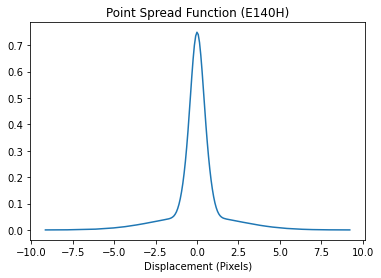

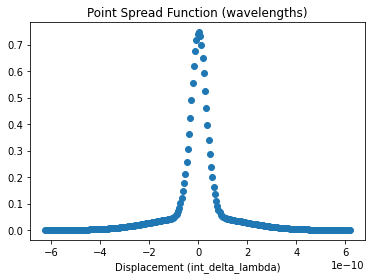

In [49]:
#get pixel_location and spectral_response from PSF file
pixel_location, spectral_response = [], []
for line in open('/Users/aoifebrennan/HST_project/HST_data/LSF/E140H.txt', 'r'):
  values = [float(s) for s in line.split()]
  pixel_location.append(values[0])
  spectral_response.append(values[2])

#need to check that stepsize for each indivual band is roughly constant
stepsize_1517 = (lambda_data_1517[1]-lambda_data_1517[0])/u.cm
stepsize_1535 = (lambda_data_1535[1]-lambda_data_1535[0])/u.cm

#create lists for both and plot
pixel_location = np.array(pixel_location)
spectral = np.array(spectral_response)
plt.plot(pixel_location, spectral)
plt.title('Point Spread Function (E140H)')
plt.xlabel('Displacement (Pixels)')
plt.ylabel('')
plt.show()

#currently we have pixel location in terms of the displacement of pixels, we want displacement in terms of delta_lambda (interger)
#we want fine wavelength array to be fine enough that we have approx 10 points acrooss FWHM
#also want the narrowest lines in data to be sufficiently sampled

psfcoarsewav_1517 = pixel_location*stepsize_1517
psffinewav_1517 = np.arange(np.floor(len(psfcoarsewav_1517)*(psfcoarsewav_1517[1]-psfcoarsewav_1517[0])/10**-11.4))*10**-11.4+pixel_location[0]*stepsize_1517

psfcoarsewav_1535 = pixel_location*stepsize_1535
psffinewav_1535 = np.arange(np.floor(len(psfcoarsewav_1535)*(psfcoarsewav_1535[1]-psfcoarsewav_1535[0])/10**-11.3))*10**-11.3+pixel_location[0]*stepsize_1535

interpol_function = scipy.interpolate.interp1d(psfcoarsewav_1517, spectral)
interpolated_spectral_response_1517 = interpol_function(psffinewav_1517)

interpol_function = scipy.interpolate.interp1d(psfcoarsewav_1535, spectral)
interpolated_spectral_response_1535 = interpol_function(psffinewav_1535)


plt.plot(psffinewav_1535, interpolated_spectral_response_1535, 'o')
plt.title('Point Spread Function (wavelengths)')
plt.xlabel('Displacement (int_delta_lambda)')

#create kernel that will be used for convolution 
kernel_1517 = CustomKernel(interpolated_spectral_response_1517) 
kernel_1535 = CustomKernel(interpolated_spectral_response_1535) 


In [50]:
# This function with a gaussian line profile works well for some lines, however if fitting is poor you should you the voigt profile instead
Lambda_array_1517 = np.arange(1516*10**-8, 1524*10**-8, 10**-11.4) 
Lambda_array_1535 = np.arange(1534*10**-8, 1542*10**-8, 10**-11.3) 

def line_model(Lambda, Lambda_array, Weight, Energy, cross_section, J, J_Level, log_N, T):
    
    freq  = c/Lambda_array
    kT = (.695*T)
    Z = np.sum(Weight*np.exp(-Energy/kT))
    x = (Weight*np.exp(-Energy/kT))/Z
   
    N = float(10**log_N)
    total_tau = 0
    
    for i, item in enumerate(Lambda):
        
        freq_0 = c/item
        index = [(j) for j, items in enumerate(J_Level) if items == J[i]]
        x_value = np.take(x, index)
       
        doppler_width = ((freq_0)/c)*(np.sqrt((2*k*T)/m))
        line_profile = (1/(doppler_width*np.sqrt(np.pi)))*np.exp(-(((freq-freq_0)**2)/(doppler_width**2))) 
        Depth = (N*cross_section[i]*x_value*line_profile)
        total_tau+=Depth

    Intensity = 1*(np.exp(-total_tau))
    return(Intensity)


In [51]:
def log_likelihood(theta, lambda_data_1535, flux_data_1535, yerr_data_1535, lambda_data_1517, flux_data_1517, yerr_data_1517):
    T, log_N, Rad_V, Rad_V_1517 = theta
    
    Intensity_1535 = line_model(Lambda_1535, Lambda_array_1535, Weight, Energy, cross_section_1535, J_1535, J_Level, log_N, T)
    Intensity_1517 = line_model(Lambda_1517, Lambda_array_1517, Weight, Energy, cross_section_1517, J_1517, J_Level, log_N, T) 
    
    delta_lambda = ((Rad_V*100000/c)*1535e-8)
    Lambda_list = []
    for i in (Lambda_array_1535):
        Lambda_list.append(i+delta_lambda)
    
    convolved = convolve_fft(Intensity_1535, kernel_1535) 
    interpol_function = scipy.interpolate.interp1d(Lambda_list, convolved, fill_value="extrapolate")
    model_1535 = interpol_function(lambda_data_1535)
    
    delta_lambda = ((Rad_V_1517*100000/c)*1517e-8)
    Lambda_list = []
    for i in (Lambda_array_1517):
        Lambda_list.append(i+delta_lambda)
    
    convolved = convolve_fft(Intensity_1517, kernel_1517) 
    interpol_function = scipy.interpolate.interp1d(Lambda_list, convolved, fill_value="extrapolate")
    model_1517 = interpol_function(lambda_data_1517)
    
    sigma2_1535 = yerr_data_1535**2
    sigma2_1517 = yerr_data_1517**2

    return (-0.5 * np.sum(((flux_data_1535) - model_1535) ** 2 / sigma2_1535))+(-0.5 * np.sum(((flux_data_1517) - model_1517) ** 2 / sigma2_1517))

In [52]:
def log_prior(theta):    
    T, log_N, Rad_V, Rad_V_1517 = theta
    if 1 < T < 300 and 1 < log_N < 80 and 1 < Rad_V < 10 and 1 < Rad_V_1517 < 5 :
        return 0
    return -np.inf

def log_probability(theta, lambda_data_1535, flux_data_1535, yerr_data_1535, lambda_data_1517, flux_data_1517, yerr_data_1517):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, lambda_data_1535, flux_data_1535, yerr_data_1535, lambda_data_1517, flux_data_1517, yerr_data_1517)

In [ ]:
import emcee

pos = np.array([70, 20, 5, 3])+np.random.randn(32,4)*1e-2*np.array([70, 20, 5, 3])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(lambda_data_1535, flux_data_1535, yerr_data_1535, lambda_data_1517, flux_data_1517, yerr_data_1517))
sampler.run_mcmc(pos, 2000, progress=True, skip_initial_state_check=True);